# **Final Project Report**

**Jupyter Notebook** : https://github.com/santhosh1299/DTSC-Finance/blob/main/DTSC_Project_Report.ipynb

**Analysis Domain:** Finance

**Collaborators:**
* Niranjan Cholendiran
* Santhosh Pattamudu Manoharan
* Saaijeesh Sottalu Naresh
* Makayla Johnson



# **Introduction**

In today's highly competitive business landscape, companies face the ongoing challenge of strategically allocating their marketing budgets across various advertising channels, to drive sales and achieve a substantial return on investment. This report delves into the heart of this challenge and presents a comprehensive solution leveraging the power of "Market Mix Modeling" (MMM).

# **Data Source**

For this project, we have used a sample dataset provided by Robyn, an open-source MMM package developed by Meta Marketing Science. This dataset comprises 208 weeks' worth of sales data, offering a deep insight into the dynamics of an organization's revenue generation.

Data Source: https://github.com/facebookexperimental/Robyn

This dataset consists:

1. The allocation of financial resources across five advertising channels: TV, Print, Out-Of-Home advertising, Facebook, and Search.
2. Metrics related to media exposure, encompassing impressions and clicks, for two of the most influential media channels: Facebook and Search.
3. The role of organic media without monetary investment, such as newsletters.
4. External factors influencing sales, including events, holidays, and the performance of competitors.

# **Problem Statement**

What is the optimal allocation ratio for distributing advertising funds among diverse media channels to achieve the objective of maximizing future sales?

# **Solution**

To solve this problem, we have briefly taken the following approach to solve this problem:

1. Identified the key advertising channels that exerts the most significant influence on sales.
2. Constructed a ridge regression model using the historical media spending data in these influential channels alongside the corresponding sales outcomes.
3. Utilized the insights extracted from the model's $\beta$ coefficients to identify the most advantageous budget allocation strategy.

In the sections that follow, we provide a detailed account of our approach, methodology, findings, and recommendations.

In [16]:
#import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Pre-processing

In [17]:
#read the csv file
df=pd.read_csv("Robyn_dt_simulated_weekly.csv")
df.sample(5)

,Unnamed: 0,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
4,5,2015-12-21,2.215953e+06,0.0,520005,0.000000,8.802269e+06,28401.744069,27100,7105985,20687.478156,na,15478.000000
155,156,2018-11-12,2.666240e+06,430131.9,0,0.000000,1.170623e+08,0.000000,0,7958631,261854.245872,na,19401.653846
195,196,2019-08-19,1.397435e+06,0.0,0,24152.000000,9.831605e+07,0.000000,0,4520254,292347.534332,na,19401.653846
50,51,2016-11-07,2.826128e+06,0.0,267379,86578.666667,6.403331e+07,42223.992695,31200,8832206,208648.339566,na,29426.000000
141,142,2018-08-06,2.009478e+06,97811.2,173577,54001.000000,0.000000e+00,76885.476551,65800,6045317,0.000000,na,59318.000000


In [18]:
# lower the column headings to maintain a consitent format
df.columns= df.columns.str.lower()

# 2. Feature Selection

Our objective is to only estimate media spends to achieve the revenue goal, so select only the media spend columns.

In [9]:
df_selected= df[['date','tv_s','ooh_s','print_s','search_s','facebook_s','revenue']]
df_selected.head()

,date,tv_s,ooh_s,print_s,search_s,facebook_s,revenue
0,2015-11-23,167687.6,0,95463.666667,0,228213.987444,2.754372e+06
1,2015-11-30,214600.9,0,0.000000,31000,34258.573511,2.584277e+06
2,2015-12-07,0.0,248022,3404.000000,28400,127691.261335,2.547387e+06
3,2015-12-14,625877.3,0,132600.000000,31900,84014.720306,2.875220e+06
4,2015-12-21,0.0,520005,0.000000,27100,20687.478156,2.215953e+06


In [21]:
# Check for null values in the features
df_selected.isnull().any()

date          False
tv_s          False
ooh_s         False
print_s       False
search_s      False
facebook_s    False
revenue       False
dtype: bool

The dataset does not have any null entires.

# 3. Data Exploration

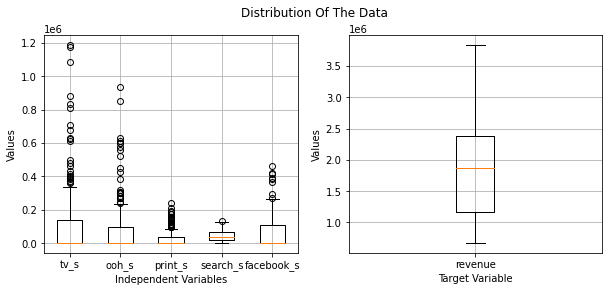

In [32]:
#plot a Box and Whisker plot for all independent and dependent variables
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
#plot for independent varaibles
df_plot= df_selected[['tv_s', 'ooh_s', 'print_s', 'search_s', 'facebook_s']]
ax1.boxplot(df_plot.values, labels=df_plot.columns)
ax1.set_xlabel('Independent Variables')
ax1.set_ylabel('Values')
ax1.grid(True)
# plot for target varaible
df_plot= df_selected[['revenue']]
ax2.boxplot(df_plot.values, labels=df_plot.columns)
ax2.set_xlabel('Target Variable')
ax2.set_ylabel('Values')
ax2.grid(True)
fig.suptitle('Distribution Of The Data')
plt.show()


* The company received a minimum of 672k sales without any marketing efforts and it went upto 3.8M, marking a remarkable 470% increase, following the implementation of marketing tactics.
* The presence of numerous outliers in the independent variables may possibly  due to the influence of external factors.

## Possible Bias in the Data

**Contextual Bias:**

The context in which ads are displayed or recommendations are made can introduce bias. For example, showing certain ads in specific geographic regions can result in biased outcomes.

**Seasonal Bias:**

Some markets or products may exhibit strong seasonality. If the data is preprocessed to remove these outliers it can result in inaccurate conclusions about the effectiveness of marketing efforts.

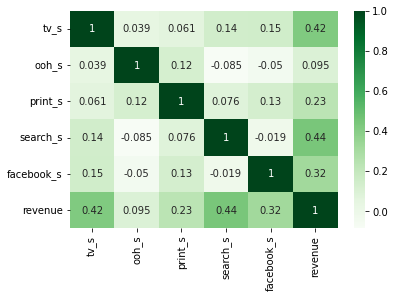

In [13]:
# Check the relationship (correlation) between the columns
sns.heatmap(df_selected.corr(), annot=True, cmap='Greens')
plt.show()

* Spends in TV and Search channels have high impact (correlation) on revenue.
* Out Of Home (OOH) advertising spends have the lowest impact on the revenue.

In [22]:
# Drop the low correated column
df_corr= df_selected.drop(columns=['ooh_s'])
df_corr.head()

,date,tv_s,print_s,search_s,facebook_s,revenue
0,2015-11-23,167687.6,95463.666667,0,228213.987444,2.754372e+06
1,2015-11-30,214600.9,0.000000,31000,34258.573511,2.584277e+06
2,2015-12-07,0.0,3404.000000,28400,127691.261335,2.547387e+06
3,2015-12-14,625877.3,132600.000000,31900,84014.720306,2.875220e+06
4,2015-12-21,0.0,0.000000,27100,20687.478156,2.215953e+06


# 4. Modeling

In [11]:
# Order the data by date
df_corr.sort_values('date',inplace= True)

In [23]:
# Drop the date column as it is not considered as an influencial variable in this analysis
df_corr.drop(columns=['date'],inplace=True)
df_corr.head()

,tv_s,print_s,search_s,facebook_s,revenue
0,167687.6,95463.666667,0,228213.987444,2.754372e+06
1,214600.9,0.000000,31000,34258.573511,2.584277e+06
2,0.0,3404.000000,28400,127691.261335,2.547387e+06
3,625877.3,132600.000000,31900,84014.720306,2.875220e+06
4,0.0,0.000000,27100,20687.478156,2.215953e+06


In [24]:
# Normalize the values to ensure all features contribute equally
scaler=preprocessing.MinMaxScaler()
scaled=scaler.fit_transform(df_corr)
df_norm=pd.DataFrame(scaled, columns= df_corr.columns)
df_norm.describe()

,tv_s,print_s,search_s,facebook_s,revenue
count,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.093920,0.116803,0.330845,0.139325,0.364436
std,0.180696,0.203089,0.263004,0.205213,0.226994
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.131618,0.000000,0.156234
50%,0.000000,0.000000,0.268829,0.000000,0.381034
75%,0.116464,0.149357,0.477442,0.235255,0.540733
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Split the train data as the initial 70% of the weeks and use the remaining 30% for testing
total_rows= len(df_norm)
num_train_rows= int(70*total_rows/100)
input_col_num= df_norm.shape[1]-1
df_train_x= df_norm.iloc[1:num_train_rows,:input_col_num]
df_train_y= df_norm.iloc[1:num_train_rows,input_col_num:]
df_test_x= df_norm.iloc[num_train_rows:,:input_col_num]
df_test_y= df_norm.iloc[num_train_rows:,input_col_num:]
print("Training input shape:",df_train_x.shape)
print("Training output shape:",df_train_y.shape)
print("Testing input shape:",df_test_x.shape)
print("Testing output shape:",df_test_y.shape)

Training input shape: (144, 4)
Training output shape: (144, 1)
Testing input shape: (63, 4)
Testing output shape: (63, 1)


In [27]:
# Train the regression model and evaluate it
ridge_model = Ridge(alpha=3.0)
ridge_model.fit(df_train_x, df_train_y)
y_pred= ridge_model.predict(df_test_x)
mse_rr = mean_squared_error(df_test_y, y_pred)
r2_rr = r2_score(df_test_y, y_pred)

print("MSE:",mse_rr)
print("R2 score:", r2_rr)

MSE: 0.02927144850834009
R2 score: 0.41148076043421267


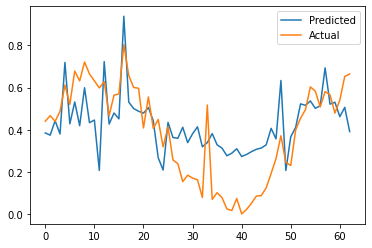

In [29]:
# Compare the prdicted values with the actual sales in a plot
plt.plot(y_pred, label= 'Predicted')
plt.plot(np.array(df_test_y['revenue']), label= 'Actual')
plt.legend()
plt.show()

The predicted result has an $R^2$ score of 0.41.

The model has captured the overall trend, however, it has to be improved to get more accurate results.

# 5. Conclusion

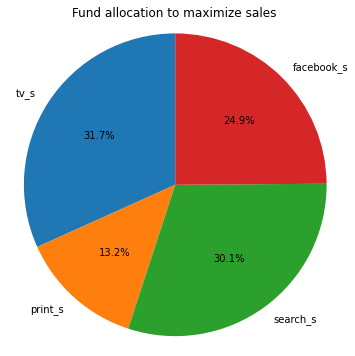

In [30]:
# Print the training results and parameters
coefficients=ridge_model.coef_[0]
labels = df_train_x.columns
sizes = coefficients # Sizes or proportions for each category
plt.figure(figsize=(6, 6))  # Optional: Set the figure size
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Fund allocation to maximize sales')
# Show the chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The company should allocate their advertising funds in the above mentioned ratio to maximize their future sales.


# **Recommended Next Steps**

Here are a few next steps recommendation to improve the accuracy of the model:

1. **Incorporate Intermediate Metrics**: Include additional intermediate metrics such as impressions and clicks in the analysis. This will provide a more comprehensive view of the advertising campaign's effectiveness. Understanding not only sales but also the reach and response of the advertisements can lead to more informed decision-making.

2. **Account for Non-Linearity**: Explore the impact of factors like seasonality, carryover effect, and saturation effects in the model as the relationship between ad spends and sales may not always be linear.

3. **Experiment with Regression Techniques**: Diversify the approach by trying different regression techniques and incorporating hyperparameter tuning. This experimentation can help to identify the most suitable modeling method for this specific data and objectives, potentially leading to improved predictive performance.